In [2]:
!pip install -U portalocker>=2.0.0

In [3]:
!pip install torchinfo

In [4]:
!pip install git+https://github.com/PetrochukM/PyTorch-NLP.git

  Cloning https://github.com/PetrochukM/PyTorch-NLP.git to /tmp/pip-req-build-hoq__157
  Running command git clone --filter=blob:none --quiet https://github.com/PetrochukM/PyTorch-NLP.git /tmp/pip-req-build-hoq__157
  Resolved https://github.com/PetrochukM/PyTorch-NLP.git to commit 53d7edcb8e0c099efce7c2ddf8cd7c44157fcac3
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-nlp: filename=pytorch_nlp-0.5.0-py3-none-any.whl size=88718 sha256=e4e8d4faffbc61549da7acf9937009c400d72a90ef1f0af76d3ee450e00b1be6
  Stored in directory: /tmp/pip-ephem-wheel-cache-s10rv0qk/wheels/a5/93/b0/9f0138afb1271281613a5af71272c5b246fdd2d421c6fbdf88
Successfully built pytorch-nlp


In [29]:
import torch
import torchtext
import os
import collections
from sklearn.metrics import accuracy_score
from torchinfo import summary
from torchnlp import *
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [6]:
from torchtext.datasets import AG_NEWS

train_dataset = iter(AG_NEWS(split="train"))
test_dataset = iter(AG_NEWS(split="test"))
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

train_dataset, test_dataset = torchtext.datasets.AG_NEWS(root='./data')
train_dataset = list(train_dataset)
test_dataset = list(test_dataset)

In [7]:
len(train_dataset)

120000

In [8]:
for i,x in zip(range(5),train_dataset):
    print(f"{classes[x[0]]} | {x[1]}\n")

Sci/Tech | Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Sci/Tech | Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

Sci/Tech | Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

Sci/Tech | Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Sci/Tech | Oil prices soar to all-time record, pos

## Убираем стоп слова, смотрим на облако слов

- убираем стоп-слова

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def drop_stopwords(list1):
  stop_words = set(stopwords.words())
  filtered_array = [(word, count) for word, count in list1 if word not in stop_words]
  return filtered_array


In [11]:
train_dataset = drop_stopwords(train_dataset)
test_dataset = drop_stopwords(test_dataset)

for i,x in zip(range(5),train_dataset):
    print(f"{classes[x[0]]} | {x[1]}\n")

Sci/Tech | Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Sci/Tech | Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

Sci/Tech | Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

Sci/Tech | Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Sci/Tech | Oil prices soar to all-time record, pos

(-0.5, 399.5, 199.5, -0.5)

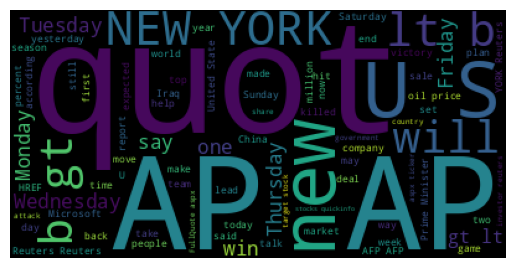

In [12]:
import pandas as pd
df = pd.DataFrame(train_dataset, columns=['target', 'text'])
text = ' '.join(df['text'])

# Генерируем облако слов и сохраняем в переменной cloud
cloud = WordCloud().generate(text)
# Выводим облако слов на экран
plt.imshow(cloud)
# Отключаем отображение осей
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

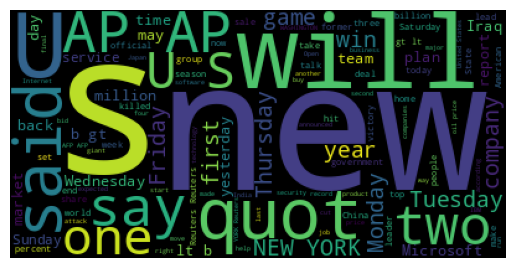

In [13]:
df = pd.DataFrame(test_dataset, columns=['target', 'text'])
text = ' '.join(df['text'])

# Генерируем облако слов и сохраняем в переменной cloud
cloud = WordCloud().generate(text)
# Выводим облако слов на экран
plt.imshow(cloud)
# Отключаем отображение осей
plt.axis('off')

### Токенизация

In [14]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
first_sentence = train_dataset[0][1]
f_tokens = tokenizer(first_sentence)
print(f'\nfirst token list:\n{f_tokens}')


first token list:
['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']


vocabulary - cловарь содержит уникальные токены из всех строк датасета и присваивает каждому токену уникальный целочисленный index, учитывая минимальную частоту равную 1.


In [15]:
from torchtext.vocab import vocab
counter = collections.Counter()
for (label, line) in train_dataset:
    counter.update(tokenizer(line))
vocabulary = vocab(counter, min_freq=1)

In [16]:
# содержит список всех токенов первого предложения
word_lookup = [list((vocabulary[w], w)) for w in f_tokens]
print(f'\nIndex lockup in 1st sentence:\n{word_lookup}')


Index lockup in 1st sentence:
[[0, 'wall'], [1, 'st'], [2, '.'], [3, 'bears'], [4, 'claw'], [5, 'back'], [6, 'into'], [7, 'the'], [8, 'black'], [9, '('], [10, 'reuters'], [11, ')'], [10, 'reuters'], [12, '-'], [13, 'short-sellers'], [14, ','], [0, 'wall'], [15, 'street'], [16, "'"], [17, 's'], [18, 'dwindling\\band'], [19, 'of'], [20, 'ultra-cynics'], [14, ','], [21, 'are'], [22, 'seeing'], [23, 'green'], [24, 'again'], [2, '.']]


### Encoding

Присваиваем каждому токену уникальный идентификатор с помощью tokenizer

In [17]:
vocab_size = len(vocabulary)

def encode(x):
    return [vocabulary.get_stoi()[s] for s in tokenizer(x)]

vec = encode(first_sentence)
print(vec)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 12, 13, 14, 0, 15, 16, 17, 18, 19, 20, 14, 21, 22, 23, 24, 2]


## Всякие полезные функции

  Проблема в том, что все строки в предложении могут иметь разную длинну, из-за чего RNN будет путаться и выдавать неверные результаты. Давай вычислим максимальную длину последовательности и добавим столько недостающих нулей, чтобы длина каждой строки совпадала с длинной самой болльшой строки

In [18]:
def padify(b):
    v = [encode(x[1]) for x in b]
    l = max(map(len,v))
    return (
        torch.LongTensor([t[0]-1 for t in b]),
        torch.stack([torch.nn.functional.pad(torch.tensor(t),(0,l-len(t)),mode='constant',value=0) for t in v])
)

## Параметры train_epoch
Аргументы:
- **optimizer** - в качестве вариации Градиентного спуска выберем Adam
- **net** - модель RNN
- **dataloader** - загрузчик данных
- **lr** - скорость обучения, по умолчанию равна 0.01
- **optimizer** - оптимизатор, используемый для обновления параметров модели
- **loss_fn** - функция потерь
- **epoch_size** - указывает максимальное количество данных для обучения в рамках одной эпохи
- **report_freq** - частота вывода отчета о точности модели, по умолчанию каждые 20 итераций

1) Функция начинает обучение, переводя модель в режим обучения (net.train()).

2) Затем она выполняет итерации по загрузчику данных:
 - обнуляет градиенты оптимизатора,
 - передает признаки в модель и получает предсказания,
 - Затем рассчитывается функция потерь между предсказаниями и истинными метками,
 - далее происходит обратное распространение ошибки ,
 - обновление параметров модели (optimizer.step()).

Далее суммируются потери, вычисляется количество правильных предсказаний и обновляется счетчик. Если достигнута заданная частота отчета, выводится точность модели.


In [33]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = torch.nn.NLLLoss(),epoch_size=None, report_freq=200):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count,i = 0,0,0,0
    for labels,features in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
        i+=1
        if i%20==0:
            print(f"{count}: accuracy={acc.item()/count}")
        if epoch_size and count>epoch_size:
            break
    return total_loss.item()/count, acc.item()/count

## RNN
В случае простого RNN каждая рекуррентная единица представляет собой простую линейную сеть, которая принимает объединенный входной вектор и вектор состояния и создает новый вектор состояния. Чтобы определить классификатор RNN, мы сначала применим слой встраивания, чтобы уменьшить размерность входного словаря, а затем наложим поверх него слой RNN:

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.rnn = torch.nn.RNN(embed_dim,hidden_dim,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, num_class)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
        x,h = self.rnn(x)
        return self.fc(x.mean(dim=1))

In [22]:
def training(learning_rate, epochs):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=padify, shuffle=True)
  net = RNNClassifier(vocab_size,64,32,len(classes)).to(device)
  train_epoch(net,train_loader, lr=learning_rate, epoch_size=epochs)
  return net

## Тестим

In [28]:
class_map = {'World':0, 'Sports':1, 'Business':2, 'Sci/Tech':3}

In [23]:
counter = collections.Counter()
for (label, line) in test_dataset:
    counter.update(tokenizer(line))
vocabulary_test = vocab(counter, min_freq=1)

In [24]:
def encode2(x):
    return [vocabulary_test.get_stoi()[s] for s in tokenizer(x)]

def padify2(b):
    v = [encode2(x[1]) for x in b]
    l = max(map(len,v))
    return (torch.LongTensor([t[0]-1 for t in b]),
            torch.stack([torch.nn.functional.pad(torch.tensor(t),(0,l-len(t)),mode='constant',value=0) for t in v]))

In [37]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=padify2, shuffle=True)
net = training(0.01, 200)

In [32]:
target_arr = []
pred_arr = []
with torch.no_grad():
    for batch_idx, (target, data) in enumerate(test_loader):
        word_lookup = [vocabulary_test.get_itos()[w] for w in data[batch_idx]]
        unknow_vals = {'<unk>'}
        word_lookup = [ele for ele in word_lookup if ele not in unknow_vals]

        data, target = data.to(device), target.to(device)
        pred = net(data)
        target_arr.append(classes[target[batch_idx]])
        pred_arr.append(classes[pred[batch_idx].argmax(0)])

In [36]:
target_numeric = [class_map[c] for c in target_arr]
predictions_numeric = [class_map[c] for c in pred_arr]
accuracy = accuracy_score(target_numeric, predictions_numeric)

print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.92
